In [ ]:
!pip install nltk wordcloud

In [ ]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Wordcloud
from wordcloud import WordCloud

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Download NLTK resources (first time only)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/DA Project datasets/amazon_alexa.csv")

# Quick overview
print(df.shape)
df.head()


(3150, 5)


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [ ]:
df.info()
df.describe(include="all")
df['feedback'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


,count
feedback,
1,2893
0,257


In [ ]:
# Check missing values
print("Missing values:\n", df.isnull().sum())

# Check duplicates
print("Duplicate rows:", df.duplicated().sum())


Missing values:
 rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64
Duplicate rows: 715


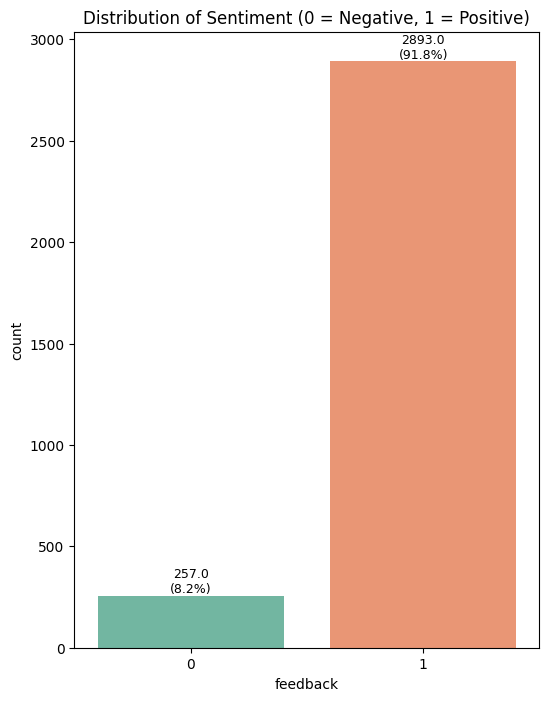

,proportion
feedback,
1,0.918413
0,0.081587


In [ ]:
plt.figure(figsize=(6,8))
ax = sns.countplot(x="feedback", data=df, palette="Set2")
plt.title("Distribution of Sentiment (0 = Negative, 1 = Positive)")

# Add values on bars
total = len(df)
for p in ax.patches:
    count = p.get_height()
    percentage = f"{100 * count/total:.1f}%"
    ax.annotate(f"{count}\n({percentage})",
                (p.get_x() + p.get_width()/2., count),
                ha="center", va="bottom", fontsize=9)

plt.show()

# Still display normalized counts if needed
df["feedback"].value_counts(normalize=True)


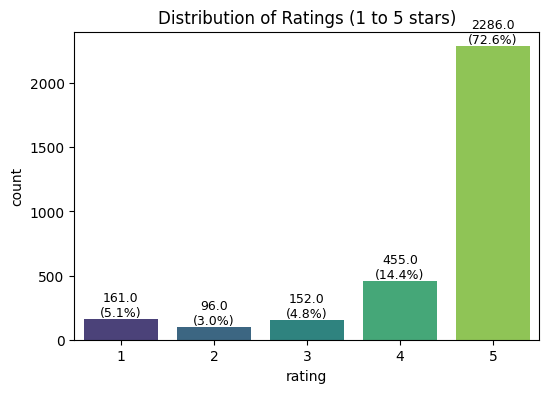

In [ ]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x="rating", data=df, palette="viridis")
plt.title("Distribution of Ratings (1 to 5 stars)")

# Add values on bars
total = len(df)
for p in ax.patches:
    count = p.get_height()
    percentage = f"{100 * count/total:.1f}%"
    ax.annotate(f"{count}\n({percentage})",
                (p.get_x() + p.get_width()/2., count),
                ha="center", va="bottom", fontsize=9)

plt.show()


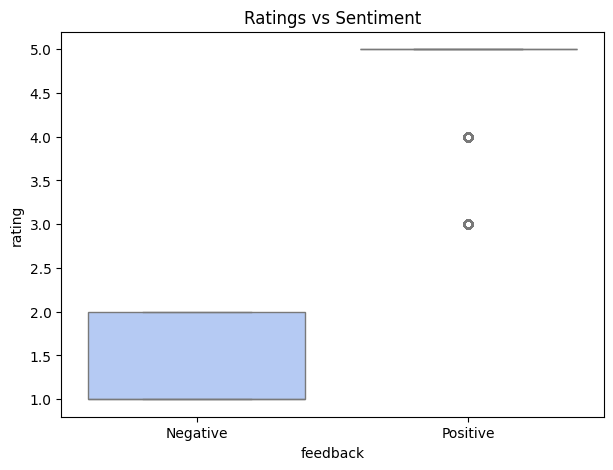

In [ ]:
plt.figure(figsize=(7,5))
sns.boxplot(x="feedback", y="rating", data=df, palette="coolwarm")
plt.title("Ratings vs Sentiment")
plt.xticks([0,1], ["Negative","Positive"])
plt.show()


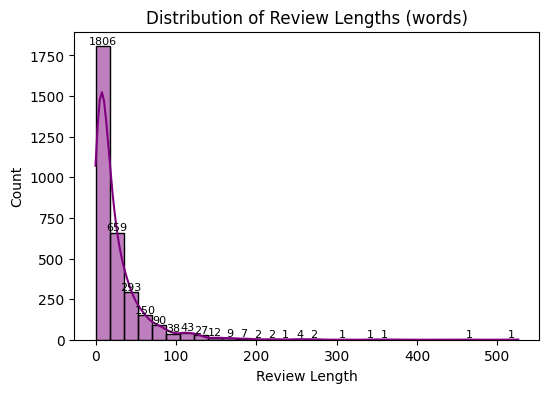

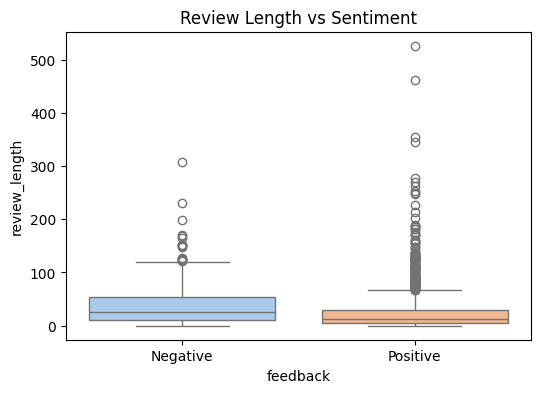

In [ ]:

# Add column for review text length
df["review_length"] = df["verified_reviews"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(6,4))
ax = sns.histplot(df["review_length"], bins=30, kde=True, color="purple")
plt.title("Distribution of Review Lengths (words)")
plt.xlabel("Review Length")

# Add values on bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # skip empty bins
        ax.text(p.get_x() + p.get_width()/2., height, int(height),
                ha="center", va="bottom", fontsize=8)

plt.show()


# Compare length by sentiment
plt.figure(figsize=(6,4))
sns.boxplot(x="feedback", y="review_length", data=df, palette="pastel")
plt.title("Review Length vs Sentiment")
plt.xticks([0,1], ["Negative","Positive"])
plt.show()


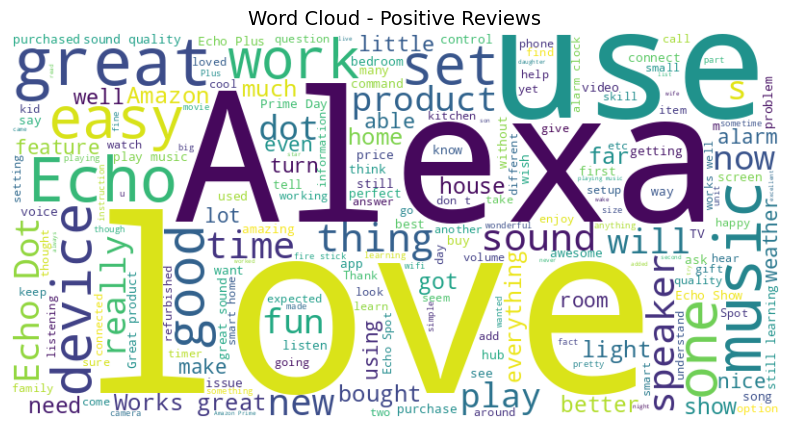

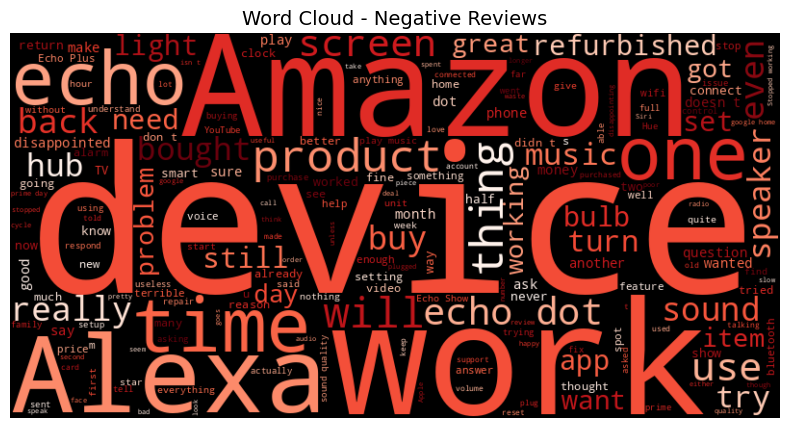

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# Clean reviews: drop NaN and ensure strings
df["verified_reviews"] = df["verified_reviews"].astype(str)

# Positive reviews
pos_text = " ".join(df[df["feedback"]==1]["verified_reviews"].dropna().astype(str))
pos_wc = WordCloud(width=800, height=400, stopwords=STOPWORDS, background_color="white").generate(pos_text)

plt.figure(figsize=(10,5))
plt.imshow(pos_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Positive Reviews", fontsize=14)
plt.show()

# Negative reviews
neg_text = " ".join(df[df["feedback"]==0]["verified_reviews"].dropna().astype(str))
neg_wc = WordCloud(width=800, height=400, stopwords=STOPWORDS, background_color="black", colormap="Reds").generate(neg_text)

plt.figure(figsize=(10,5))
plt.imshow(neg_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Negative Reviews", fontsize=14)
plt.show()


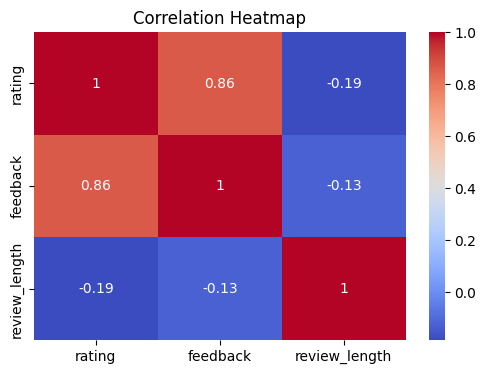

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation/numbers
    text = re.sub(r"[^a-z\s]", "", text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords + stemming
    tokens = [stemmer.stem(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

# Apply preprocessing
df["cleaned_review"] = df["verified_reviews"].astype(str).apply(clean_text)
df[["verified_reviews", "cleaned_review"]].head()


,verified_reviews,cleaned_review
0,Love my Echo!,love echo
1,Loved it!,love
2,"Sometimes while playing a game, you can answer...",sometim play game answer question correctli al...
3,I have had a lot of fun with this thing. My 4 ...,lot fun thing yr old learn dinosaur control li...
4,Music,music


In [ ]:
X = df["cleaned_review"]
y = df["feedback"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape, X_test.shape)


(2520,) (630,)



⚡ Training untuned Logistic Regression...

⚡ Training untuned Naive Bayes...

⚡ Training untuned Random Forest...


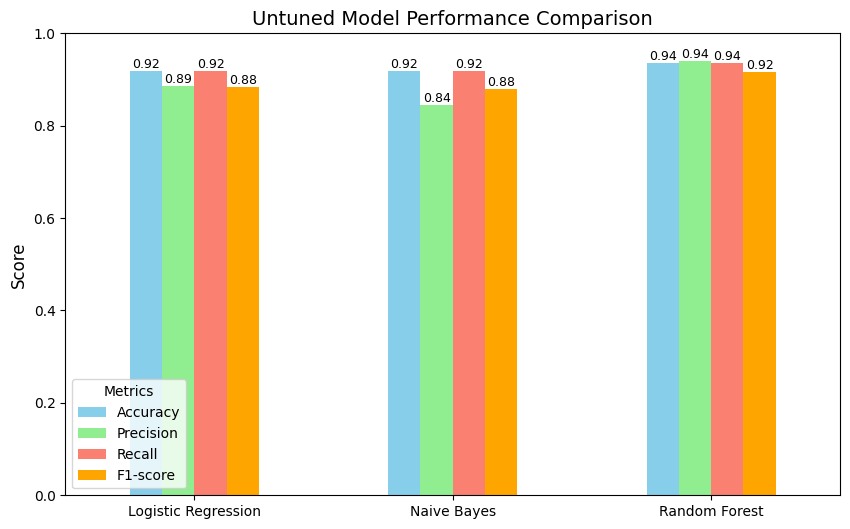

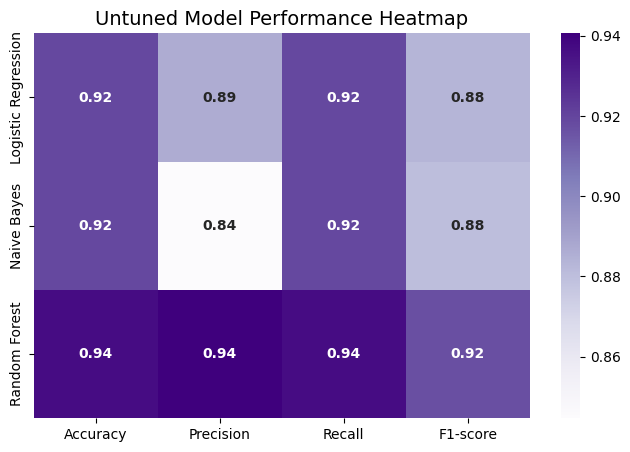

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Dictionary to store untuned results
untuned_results = {}

for name, pipe in pipelines.items():
    print(f"\n⚡ Training untuned {name}...")

    # Train directly without GridSearch
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Save results
    untuned_results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "report": classification_report(y_test, y_pred, output_dict=True),
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }

# Convert to DataFrame
untuned_metrics_df = pd.DataFrame({
    model: {
        "Accuracy": untuned_results[model]["accuracy"],
        "Precision": untuned_results[model]["report"]["weighted avg"]["precision"],
        "Recall": untuned_results[model]["report"]["weighted avg"]["recall"],
        "F1-score": untuned_results[model]["report"]["weighted avg"]["f1-score"]
    }
    for model in untuned_results
}).T

# --- Bar chart with values ---
ax = untuned_metrics_df.plot(kind="bar", figsize=(10,6), color=["skyblue","lightgreen","salmon","orange"])
plt.title("Untuned Model Performance Comparison", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title="Metrics")

# Add values
for p in ax.patches:
    value = p.get_height()
    ax.annotate(f"{value:.2f}",
                (p.get_x() + p.get_width()/2., value),
                ha="center", va="bottom", fontsize=9)

plt.show()

# --- Heatmap ---
plt.figure(figsize=(8,5))
sns.heatmap(untuned_metrics_df, annot=True, cmap="Purples", fmt=".2f", annot_kws={"size":10, "weight":"bold"})
plt.title("Untuned Model Performance Heatmap", fontsize=14)
plt.show()


In [ ]:
# Define pipelines
pipelines = {
    "Logistic Regression": Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), max_features=10000, min_df=2)),
        ("clf", LogisticRegression(max_iter=500))
    ]),
    "Naive Bayes": Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), max_features=10000, min_df=2)),
        ("clf", MultinomialNB())
    ]),
    "Random Forest": Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), max_features=10000, min_df=2)),
        ("clf", RandomForestClassifier())
    ])
}



🔍 Hyperparameter tuning for Logistic Regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

🔍 Hyperparameter tuning for Naive Bayes...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

🔍 Hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


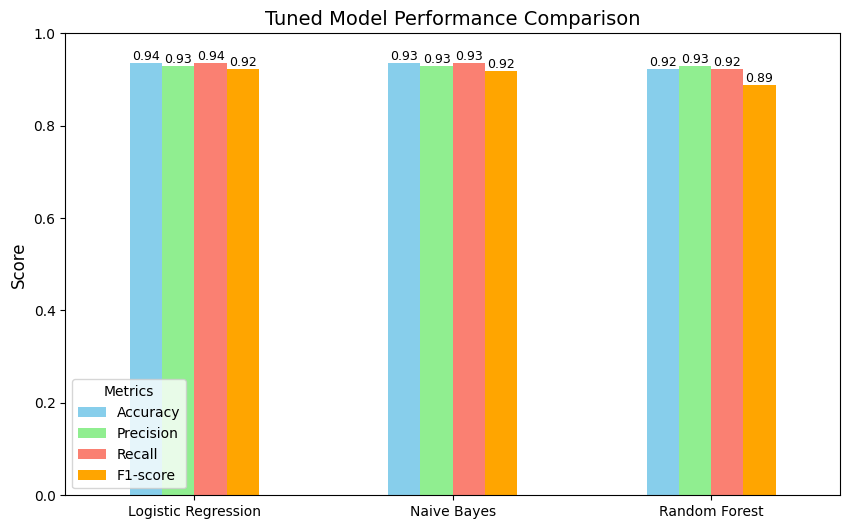

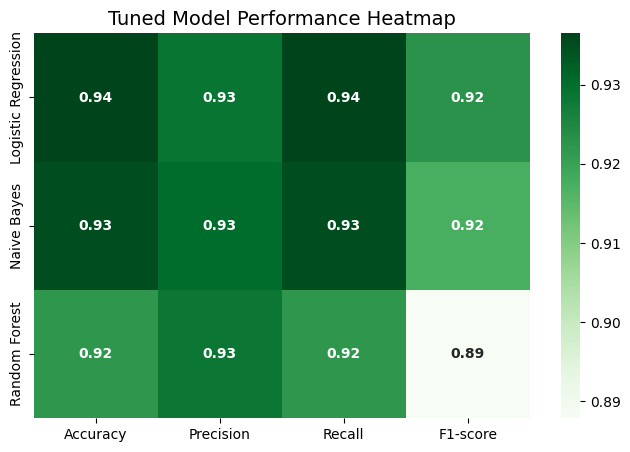

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform

# Define richer parameter grids
param_distributions = {
    "Logistic Regression": {
        "clf__C": uniform(0.01, 10),        # continuous distribution
        "clf__solver": ["liblinear", "lbfgs"]
    },
    "Naive Bayes": {
        "clf__alpha": uniform(0.01, 2.0)    # smoother range
    },
    "Random Forest": {
        "clf__n_estimators": randint(100, 1000),
        "clf__max_depth": [None, 10, 20, 30],
        "clf__min_samples_split": randint(2, 10),
        "clf__min_samples_leaf": randint(1, 5)
    }
}

# Stratified 5-fold CV
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store tuned results
tuned_results = {}

for name, pipe in pipelines.items():
    print(f"\n🔍 Hyperparameter tuning for {name}...")

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions[name],
        n_iter=20,                # number of random samples
        scoring="f1_weighted",    # optimize F1
        n_jobs=-1,
        cv=cv_strategy,
        random_state=42,
        verbose=1
    )

    search.fit(X_train, y_train)
    y_pred = search.predict(X_test)

    tuned_results[name] = {
        "best_params": search.best_params_,
        "accuracy": accuracy_score(y_test, y_pred),
        "report": classification_report(y_test, y_pred, output_dict=True),
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }

# Convert results to DataFrame
tuned_metrics_df = pd.DataFrame({
    model: {
        "Accuracy": tuned_results[model]["accuracy"],
        "Precision": tuned_results[model]["report"]["weighted avg"]["precision"],
        "Recall": tuned_results[model]["report"]["weighted avg"]["recall"],
        "F1-score": tuned_results[model]["report"]["weighted avg"]["f1-score"]
    }
    for model in tuned_results
}).T

# --- Bar chart with values ---
ax = tuned_metrics_df.plot(kind="bar", figsize=(10,6), color=["skyblue","lightgreen","salmon","orange"])
plt.title("Tuned Model Performance Comparison", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title="Metrics")

for p in ax.patches:
    value = p.get_height()
    ax.annotate(f"{value:.2f}",
                (p.get_x() + p.get_width()/2., value),
                ha="center", va="bottom", fontsize=9)

plt.show()

# --- Heatmap ---
plt.figure(figsize=(8,5))
sns.heatmap(tuned_metrics_df, annot=True, cmap="Greens", fmt=".2f",
            annot_kws={"size":10, "weight":"bold"})
plt.title("Tuned Model Performance Heatmap", fontsize=14)
plt.show()


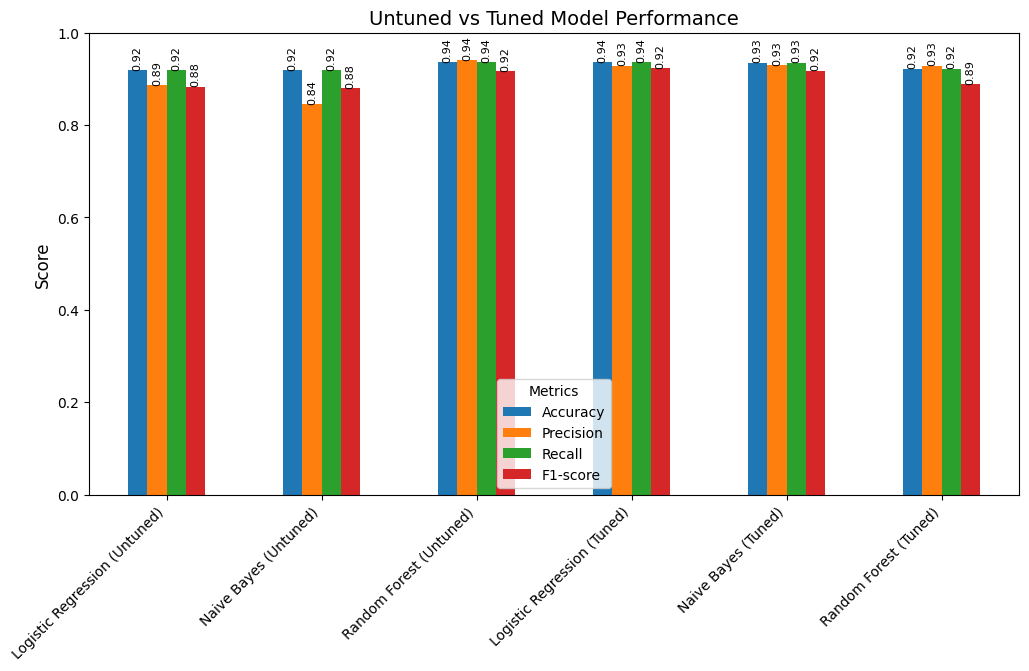

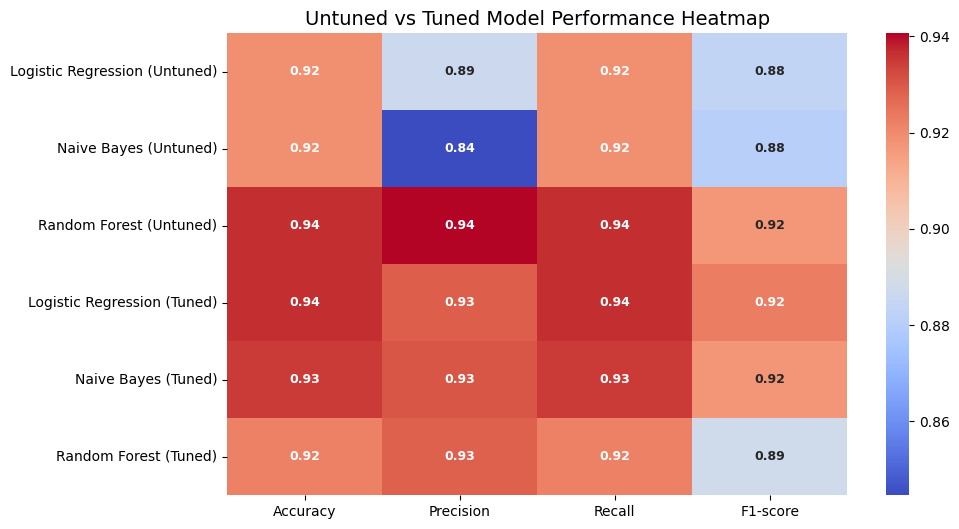

In [ ]:
# Build comparison DataFrame
comparison_df = pd.DataFrame({
    f"{model} (Untuned)": {
        "Accuracy": untuned_results[model]["accuracy"],
        "Precision": untuned_results[model]["report"]["weighted avg"]["precision"],
        "Recall": untuned_results[model]["report"]["weighted avg"]["recall"],
        "F1-score": untuned_results[model]["report"]["weighted avg"]["f1-score"]
    }
    for model in untuned_results
})

for model in tuned_results:
    comparison_df[f"{model} (Tuned)"] = {
        "Accuracy": tuned_results[model]["accuracy"],
        "Precision": tuned_results[model]["report"]["weighted avg"]["precision"],
        "Recall": tuned_results[model]["report"]["weighted avg"]["recall"],
        "F1-score": tuned_results[model]["report"]["weighted avg"]["f1-score"]
    }

# Transpose for easier plotting
comparison_df = comparison_df.T

# --- Grouped Bar Chart ---
ax = comparison_df.plot(kind="bar", figsize=(12,6), color=["skyblue","lightgreen","salmon","orange"])
plt.title("Untuned vs Tuned Model Performance", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Metrics")

# Add values
for p in ax.patches:
    value = p.get_height()
    ax.annotate(f"{value:.2f}",
                (p.get_x() + p.get_width()/2., value),
                ha="center", va="bottom", fontsize=8, rotation=90)

plt.show()

# --- Heatmap ---
plt.figure(figsize=(10,6))
sns.heatmap(comparison_df, annot=True, cmap="coolwarm", fmt=".2f",
            annot_kws={"size":9, "weight":"bold"})
plt.title("Untuned vs Tuned Model Performance Heatmap", fontsize=14)
plt.show()


In [ ]:
import pandas as pd

# 1. Model Performance (Untuned & Tuned)
performance_data = []

for model in untuned_results:
    performance_data.append({
        "Model": model,
        "Type": "Untuned",
        "Accuracy": untuned_results[model]["accuracy"],
        "Precision": untuned_results[model]["report"]["weighted avg"]["precision"],
        "Recall": untuned_results[model]["report"]["weighted avg"]["recall"],
        "F1-score": untuned_results[model]["report"]["weighted avg"]["f1-score"]
    })

for model in tuned_results:
    performance_data.append({
        "Model": model,
        "Type": "Tuned",
        "Accuracy": tuned_results[model]["accuracy"],
        "Precision": tuned_results[model]["report"]["weighted avg"]["precision"],
        "Recall": tuned_results[model]["report"]["weighted avg"]["recall"],
        "F1-score": tuned_results[model]["report"]["weighted avg"]["f1-score"]
    })

df_performance = pd.DataFrame(performance_data)

# 2. Confusion Matrices
confusion_data = []
for model, res in tuned_results.items():
    cm = res["confusion_matrix"]
    tn, fp, fn, tp = cm.ravel()
    confusion_data.append({"Model": model, "TN": tn, "FP": fp, "FN": fn, "TP": tp, "Type": "Tuned"})

for model, res in untuned_results.items():
    cm = res["confusion_matrix"]
    tn, fp, fn, tp = cm.ravel()
    confusion_data.append({"Model": model, "TN": tn, "FP": fp, "FN": fn, "TP": tp, "Type": "Untuned"})

df_confusion = pd.DataFrame(confusion_data)

# 3. Distribution Data
df_sentiment = df["feedback"].value_counts(normalize=False).reset_index()
df_sentiment.columns = ["Sentiment", "Count"]

if "rating" in df.columns:
    df_rating = df["rating"].value_counts().reset_index()
    df_rating.columns = ["Rating", "Count"]
else:
    df_rating = pd.DataFrame()

# 4. Review Length Stats
df_length_summary = df.groupby("feedback")["review_length"].agg(["count","mean","median"]).reset_index()

# 5. Word Frequencies
from collections import Counter

pos_words = " ".join(df[df.feedback==1]["cleaned_review"]).split()
neg_words = " ".join(df[df.feedback==0]["cleaned_review"]).split()

df_word_pos = pd.DataFrame(Counter(pos_words).most_common(50), columns=["Word", "Frequency"])
df_word_pos["Sentiment"] = "Positive"

df_word_neg = pd.DataFrame(Counter(neg_words).most_common(50), columns=["Word", "Frequency"])
df_word_neg["Sentiment"] = "Negative"

df_words = pd.concat([df_word_pos, df_word_neg])

# --- Export all datasets ---
with pd.ExcelWriter("tableau_dashboard_data.xlsx") as writer:
    df_performance.to_excel(writer, sheet_name="Model_Performance", index=False)
    df_confusion.to_excel(writer, sheet_name="Confusion_Matrices", index=False)
    df_sentiment.to_excel(writer, sheet_name="Sentiment_Distribution", index=False)
    df_rating.to_excel(writer, sheet_name="Rating_Distribution", index=False)
    df_length_summary.to_excel(writer, sheet_name="Review_Length", index=False)
    df_words.to_excel(writer, sheet_name="Word_Frequencies", index=False)

print("✅ Exported 'tableau_dashboard_data.xlsx' with all sheets ready for Tableau.")

# ---- Download in Colab ----
from google.colab import files
files.download("tableau_dashboard_data.xlsx")

✅ Exported 'tableau_dashboard_data.xlsx' with all sheets ready for Tableau.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>